<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
<br>汉化的库: <a href="https://github.com/GoatCsu/CN-LLMs-from-scratch.git">https://github.com/GoatCsu/CN-LLMs-from-scratch.git</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# 第三章: Attention

本章所需要的包

In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))
#导入并确认库

torch version: 2.8.0+cu126


- LLM的核心:Attention
- 译者:可以直接看论文呀!
- [Attention is all you need](https://arxiv.org/abs/1706.03762)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/01.webp?123" width="500px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/02.webp" width="600px">

## 3.1 长序列的建模

- 没有代码
- 逐字翻译文本通常不可行，因为源语言和目标语言在语法结构上存在差异：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/03.webp" width="400px">

- 在Transformer模型出现之前，机器翻译任务主要依赖于编码器(encoder)-解码器(decoder)架构的循环神经网络（RNNs）。
- 在这种架构中，编码器逐词处理源语言序列，并通过隐藏状态（神经网络中的中间层）生成输入序列的表示：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/04.webp" width="500px">

## 3.2 注意力机制高效捕获数据关系

- 本节不涉及代码。
- 借助注意力机制，文本生成解码器能够选择性地关注所有输入token，从而在生成特定输出token时，动态分配不同输入token的重要性系数

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/05.webp" width="500px">

- Transformer中的自注意力机制是一种关键技术，它通过让序列中的每个位置与其他所有位置交互并计算相关性，从而增强输入表示的上下文信息。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/06.webp" width="300px">

## 3.3 自注意力关注的不同部分

### 3.3.1 无可变参数的自注意力模型

- 本节介绍了一种高度简化的自注意力变体，不包含任何可训练的权重。
- 该变体仅用于说明目的，并非Transformer中实际使用的注意力机制。
- 下一节（3.3.2节）将扩展此简易模型，实现真正的自注意力机制。
- 假设给定一个输入序列 $x^{(1)}$ 到 $x^{(T)}$：
  - 输入是一个文本（例如，一句已被处理为token嵌入的句子，如“Your journey starts with one step”），具体处理方法在第2章中已有描述。
  - 例如，$x^{(1)}$ 是表示单词“Your”的d维向量，以此类推。

- **目标：** 为输入序列中的每个元素 $x^{(i)}$（从 $x^{(1)}$ 到 $x^{(T)}$）计算上下文向量 $z^{(i)}$（$z$ 和 $x$ 的维度相同）。
    - 上下文向量 $z^{(i)}$ 是对输入 $x^{(1)}$ 到 $x^{(T)}$ 的加权求和。
    - 上下文向量是针对特定输入的“上下文”相关表示。
      - 以第二个输入 $x^{(2)}$ 为例，说明具体计算过程。
      - 第二个上下文向量 $z^{(2)}$ 是对所有输入 $x^{(1)}$ 到 $x^{(T)}$ 的加权求和，权重由相对于 $x^{(2)}$ 的注意力权重决定。
      - 注意力权重决定了每个输入元素对 $z^{(2)}$ 的贡献程度。
      - 简而言之，$z^{(2)}$ 是 $x^{(2)}$ 的增强版本，融合了与当前任务相关的所有其他输入元素的信息。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/07.webp" width="400px">

- （请注意，此图中的数字已截断至小数点后一位，以减少视觉干扰；其他图表中的数值也可能经过类似处理。）

- 按照惯例，未归一化的注意力值称为 **“注意力得分”**，而归一化后总和为1的注意力得分称为 **“注意力权重”**。

- 下方代码逐步演示了上图的操作过程

<br>

- **步骤 1：** 计算未归一化的注意力得分 $\omega$
- 假设使用第二个输入token作为查询，即 $q^{(2)} = x^{(2)}$，通过点积计算未归一化的注意力得分：
    - $\omega_{21} = x^{(1)} \cdot q^{(2)\top}$
    - $\omega_{22} = x^{(2)} \cdot q^{(2)\top}$
    - $\omega_{23} = x^{(3)} \cdot q^{(2)\top}$
    - ...
    - $\omega_{2T} = x^{(T)} \cdot q^{(2)\top}$
- 其中，$\omega$ 是希腊字母“欧米伽”，表示未归一化的注意力得分。
    - 在 $\omega_{21}$ 中，下标“21”表示以第2个元素为查询，与第1个元素计算得分。

- 假设我们有以下输入句子，该句子已根据第3章的描述嵌入到3维向量中（此处我们使用了一个非常小的嵌入维度进行说明，以便内容可以显示在页面上）：

In [2]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
#对于一句话中的每个单词定义了一个三维的向量

- （在本书中，我们遵循机器学习和深度学习的常见惯例：训练样本以行表示，特征值以列表示；对于上述张量，每一行表示一个词，每一列表示一个嵌入维度。）

- 本节的主要目标是演示如何以第二个输入序列 $x^{(2)}$ 作为查询，计算其上下文向量 $z^{(2)}$。

- 图中展示了该过程的第一步，即通过点积操作计算 $x^{(2)}$ 与所有其他输入元素之间的注意力得分 $\omega$。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/08.webp" width="400px">

- 我们以输入序列中的第2个元素 $x^{(2)}$ 为例，计算其上下文向量 $z^{(2)}$；稍后会将此方法推广至计算所有上下文向量。
- 第一步是通过计算查询 $x^{(2)}$ 与所有输入token的点积，得到未归一化的注意力得分：

In [3]:
inputs.shape

torch.Size([6, 3])

In [4]:
inputs.shape[0]

6

In [5]:
query = inputs[1]  # 第二个输入词元作为查询向量

attn_scores_2 = torch.empty(inputs.shape[0]) #creates a 1-dimensional tensor of size 6
print(attn_scores_2) # after the initialization shows these uninitialized values, which often appear as very small or very large numbers.
#建立一个未初始化的张量来记录注意力得分,  The initial values in this tensor are uninitialized, meaning they can be anything (garbage values) until they are assigned.

for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
    # 相似性度量计算attention分数
    # 从公式上看也就是点乘

print(attn_scores_2)

tensor([-3.5110e-06,  4.4134e-41, -3.5110e-06,  4.4134e-41,  1.6403e-38,
         0.0000e+00])
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


- 补充说明：点积本质上是逐元素相乘并将所得积相加的一种简写表示：
- 点积不仅被视为一种将两个向量转化为标量值的数学工具，而且也是度量相似度的一种方式，因为它可以量化两个向量之间的对齐程度：点积越大，向量之间的对齐程度或相似度就越高。在自注意机制中，点积决定了序列中每个元素对其他元素的关注程度：点积越大，两个元素之间的相似度和注意力分数就越高。

In [6]:
res = 0.

for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]
    #累加Key*Query的成绩

print(res)
print(torch.dot(inputs[0], query))
#相当于解释了一遍点成的内部原理 - 输出证实了元素乘法的总和与点积的结果相同

tensor(0.9544)
tensor(0.9544)


- **步骤 2：** 将未归一化的注意力得分（“欧米伽”，$\omega$）归一化，使其总和为1。
- 以下是一种简单的方法，用于将未归一化的注意力得分归一化：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/09.webp" width="500px">

In [7]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
#归一化,这里是属于加权式的归一化

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


- 然而，在实践中，使用softmax函数进行归一化更为常见，因为它能够更好地处理极端值，并且在训练过程中具有更理想的梯度特性，因此推荐使用。


在实际应用中，**softmax 函数**通常比其他归一化方法（比如 sigmoid 或 hardmax）更受欢迎，原因主要有两个：

---

## ✅ 为什么使用 softmax 更常见？

### 1. **更好地处理极端值**
Softmax 的定义是：

$$
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}
$$

- 它将一个向量中的每个元素转换为一个概率分布（所有值加起来为 1）。
- 即使某些输入值非常大或非常小，softmax 仍能保持数值稳定性（尤其在使用 log-softmax 时）。
- 它能放大差异，使得最大值更接近 1，其他值更接近 0，从而更清晰地区分“最可能的选择”。

### 2. **更理想的梯度特性**
在训练神经网络时，梯度的传播非常关键：

- softmax 的导数是连续且可微的，适合反向传播。
- 它不会像 hardmax 那样导致梯度为零（hardmax 是非连续的，不能用于训练）。
- 相比 sigmoid，softmax 在多分类问题中更自然地处理多个输出之间的竞争关系。

---

## 📌 举个例子：分类任务中的 softmax

假设你有一个模型输出向量 `[2.0, 1.0, 0.1]`，表示三个类别的得分。

使用 softmax 后：

```python
import numpy as np

logits = np.array([2.0, 1.0, 0.1])
softmax = np.exp(logits) / np.sum(np.exp(logits))
print(softmax)
```

输出类似于：

```
[0.659, 0.242, 0.099]
```

这表示模型认为第一个类别的概率最高。

---

## 🔍 总结

| 特性 | softmax 的优势 |
|------|----------------|
| 数值稳定性 | 能处理极端值，避免梯度爆炸或消失 |
| 可微性 | 支持反向传播，适合训练 |
| 多分类支持 | 自然地归一化多个类别的得分 |
| 实践经验 | 在深度学习中广泛验证有效性 |

---


“梯度特性”是一个在机器学习和深度学习中非常重要的概念，尤其是在模型训练过程中。我们可以从以下几个方面来理解它：

---

## 🧮 什么是梯度？

在神经网络中，**梯度是损失函数对模型参数的导数**，它表示：

> 如果我们稍微改变某个参数，损失函数会如何变化？

梯度告诉我们该如何调整参数，以使模型的预测更准确（即损失更小）。

---

## 📈 梯度特性指什么？

“梯度特性”通常指的是一个函数在反向传播过程中表现出的**梯度行为**，包括：

### 1. **梯度是否容易计算？**
- 函数是否是**可微的**（即可以求导）？
- 导数是否有**封闭形式**（可以直接写出来）？

### 2. **梯度是否稳定？**
- 梯度是否会**爆炸**（值太大）或**消失**（值太小）？
- 是否容易导致训练停滞或不收敛？

### 3. **梯度是否有良好的数值分布？**
- 是否能提供足够的信息来更新参数？
- 是否能在多个类别之间提供**区分度**？

---

## 🧠 Softmax 的梯度特性为什么好？

相比其他函数（如 hardmax 或 sigmoid），softmax 的梯度特性更理想：

| 特性 | Softmax | Sigmoid | Hardmax |
|------|---------|---------|---------|
| 可微性 | ✅ 连续可导 | ✅ 连续可导 | ❌ 不可导 |
| 梯度稳定性 | ✅ 较稳定 | ❌ 容易梯度消失 | ❌ 无梯度 |
| 多分类支持 | ✅ 原生支持 | ❌ 仅适合二分类 | ❌ 仅输出最大值 |

例如，在多分类任务中，softmax 的梯度可以同时考虑所有类别之间的相对差异，而 sigmoid 只能独立处理每个类别。

---

## 📌 举个例子：梯度消失问题

假设你使用 sigmoid 函数处理一个很大的输入值，比如 10：

```python
import numpy as np
x = 10
sigmoid = 1 / (1 + np.exp(-x))  # ≈ 0.99995
gradient = sigmoid * (1 - sigmoid)  # ≈ 0.00005
```

这个梯度非常小，导致参数更新几乎停滞，这就是**梯度消失**。

而 softmax 的梯度在多个类别之间分布得更合理，能有效推动模型学习。

---

## ✅ 总结

“梯度特性”是指一个函数在训练过程中对梯度传播的影响，包括：

- 是否可导
- 是否数值稳定
- 是否能提供有效的参数更新方向

softmax 因为其良好的梯度特性，在多分类任务中被广泛使用。

---


这是一个非常有趣的问题！虽然“梯度特性”是一个数学和计算上的概念，但它确实可以从**物理角度类比和理解**，尤其是当我们把神经网络的训练过程看作一个**能量优化系统**时。

---

## 🧠 梯度在机器学习中的角色

在机器学习中，梯度是损失函数对参数的导数，它告诉我们：

> 如果我们稍微改变参数，损失（误差）会如何变化？

这就像在一个地形图上寻找最低点（最小损失），梯度就是告诉你往哪个方向走可以“下坡”。

---

## ⚙️ 类比到物理世界：梯度 = 力的方向

我们可以把神经网络训练类比为一个物理系统：

| 机器学习术语 | 物理类比 |
|--------------|----------|
| 损失函数 | 势能（Potential Energy） |
| 梯度 | 力（Force） |
| 参数更新 | 物体运动（沿力方向移动） |
| 学习率 | 步长或摩擦系数 |

### 举例说明：

- 在物理中，一个物体会沿着**势能最小的方向**移动（比如水流向低处）。
- 在机器学习中，参数会沿着**损失最小的方向**更新（由梯度指引）。

所以，**梯度就像是一个“力”，推动模型参数朝着更优的方向移动。**

---

## 📉 梯度消失/爆炸的物理类比

### 梯度消失：
- 类比为物体处于一个非常平坦的区域，几乎没有斜坡。
- 力非常小，物体几乎不动 → 模型参数几乎不更新。

### 梯度爆炸：
- 类比为一个非常陡峭的斜坡，力非常大。
- 物体可能会“飞出去” → 参数更新过猛，导致训练不稳定。

---

## 🔍 Softmax 的梯度特性与物理类比

Softmax 的梯度特性好，意味着：

- 它提供了**平滑且稳定的“力”**，可以有效地引导参数更新。
- 不会像 hardmax 那样突然“跳变”，也不会像 sigmoid 那样在极端值时“力几乎为零”。

这就像在一个合理设计的地形中，物体可以顺利地滑向最低点，而不会卡住或失控。

---

## ✅ 总结

虽然“梯度特性”是数学上的概念，但它可以类比为物理中的“力”或“势能变化”，帮助我们更直观地理解：

- 为什么某些函数更适合训练（比如 softmax）
- 为什么梯度消失或爆炸会导致训练失败
- 为什么我们需要设计良好的损失函数和激活函数

---


- 下面是一个简单的softmax函数实现，用于缩放并对向量元素进行归一化，使它们的和为1：

In [8]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())
##用SoftMax做归一化, 处理好极端值
#有合理的梯度数据表现力

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


- 上述简单实现可能会因输入值过大或过小而遭遇数值不稳定问题，导致溢出或下溢。
- 因此，在实践中，建议使用PyTorch内置的softmax函数，因为它经过高度优化，性能更佳：

In [9]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())
#用torch优化过的softmax对边缘值也挺友好的

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


- **步骤 3**：通过将嵌入的输入标记 $x^{(i)}$ 与注意力权重相乘，并对结果向量求和，计算上下文向量 $z^{(2)}$：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/10.webp" width="500px">

In [10]:
query = inputs[1] # 第二个输入词元作为查询向量

context_vec_2 = torch.zeros(query.shape)
#创造一个内容的零向量
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
    #把不同内容的向量+起来

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### 3.3.2 计算所有输入词元的注意力权重

#### 将其推广到所有输入序列标记：

- 上面，我们为输入2计算了注意力权重和上下文向量（如下图中高亮的行所示）。
- 接下来，我们将此计算推广到所有输入序列标记，计算对应的注意力权重和上下文向量。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/11.webp" width="400px">

- （请注意，图中的数字已四舍五入到小数点后两位；每一行的数值应相加为1.0或100%；其他图中的数字也进行了类似处理。）

- 在自注意力机制中，首先计算注意力得分，随后对这些得分进行归一化，得到总和为1的注意力权重。
- 接着，利用这些注意力权重对输入进行加权求和，生成上下文向量。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/12.webp" width="400px">

- 对所有成对元素应用之前的**步骤 1**，计算未归一化的注意力得分矩阵：

In [11]:
attn_scores = torch.empty(6, 6)
#建立个空表来储存相关联程度 -创建了一个 6x6 的空张量（矩阵），用于存储注意力得分。这个矩阵的行和列都对应于输入序列中的词元

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j) #计算外层循环的词元 x_i（作为查询 Query）与内层循环的词元 x_j（作为键 Key）之间的点积
        #一点点计算相关性并输入表格
print(attn_scores)
#事实上就是实现了两个单词之间的关联度列表输出

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


- 如果是矩阵相乘那么更有效率

In [12]:
attn_scores = inputs @ inputs.T
print(attn_scores)
#有简单的方法整合方法计算

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


- 与**第二步**相似, 我们对每一行都要归一化操作:

In [13]:
attn_weights = torch.softmax(attn_scores, dim=-1) #这一行代码将 attn_scores 矩阵的每一行（dim=-1 表示对最后一个维度进行操作）应用 softmax 函数
#dim=-1 在二维张量这里相当于dim=1, 表示跨列操作, 即要对每一行进行归一化
print(attn_weights)
#归一化处理

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


## ✅ 总结：dim 的含义和归一化方向

| 张量形状 | `dim` 值 | 归一化方向 | 哪些元素被归一化 | 每组总和为 |
|----------|-----------|--------------|------------------|-------------|
| `[6, 6]` | `dim=0`   | 跨行         | 每一列           | 1（每列）   |
| `[6, 6]` | `dim=1`   | 跨列         | 每一行           | 1（每行）   |
| `[6, 6]` | `dim=-1`  | 最后一维 = 列 | 每一行           | 1（每行）   |

---

## 🔍 小贴士：如何避免混淆？

- **看张量的 shape**，比如 `[batch_size, seq_len]`，通常 softmax 是在 `seq_len` 上做的 → `dim=-1`。
- **记住：softmax 是“归一化”，你要明确“在哪一组元素之间归一化”。**

---


- 一个快速验证

In [14]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)

print("All row sums:", attn_weights.sum(dim=-1))
#验证一下大家加起来都是1

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


- 用**step 3** 计算所有的向量:

In [15]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs) #在生成的输出张量中，每一行包含一个三维的上下文向量
#重复了上一个操作

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


-  作为合理性检查，之前计算的上下文向量 $z^{(2)} = [0.4419, 0.6515, 0.5683]$ 可以在上图的第二行找到：

In [16]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


## 3.4 可调整参数的自注意力机制

- 以下的概念框架展示了本节中开发的自注意力机制,以及这种机制是如何融入本书和本章的整体叙述与结构。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/13.webp" width="400px">

### 3.4.1 手把手的计算attention的值

- 在本节中，我们实现了原始 Transformer 架构、GPT 模型以及大多数流行 LLM 中使用的自注意力机制。  
- 这种自注意力机制被称为“缩放点积注意力”（scaled dot-product attention）。  
- 整体思路与之前相似：  
  - 我们希望计算针对特定输入元素的上下文向量，即输入向量的加权和。  
  - 为此，我们需要生成注意力权重。  
- 如你所见，与之前介绍的基本注意力机制相比，只有一些细微差异：  
  - 最显著的区别是引入了在模型训练过程中更新的权重矩阵。  
  - 这些可训练的权重矩阵至关重要，它们使模型（尤其是注意力模块）能够学习生成“优质”的上下文向量。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/14.webp" width="600px">

- 按照步骤实现自注意力机制，我们将首先介绍三个训练权重矩阵 $W_q$、$W_k$ 和 $W_v$。  
- 这三个矩阵用于通过矩阵乘法将嵌入的输入标记 $x^{(i)}$ 映射到查询向量、键向量和值向量：
- (译者: 分别是Query、Key、Value,专有名词)   

  - 查询向量：$q^{(i)} = W_q \,x^{(i)}$  
  - 键向量：$k^{(i)} = W_k \,x^{(i)}$  
  - 值向量：$v^{(i)} = W_v \,x^{(i)}$  


- 输入 $x$ 和查询向量 $q$ 的嵌入维度可以相同，也可以不同，具体取决于模型的设计和实现方式。
- 在 GPT 模型中，输入和输出维度通常是相同的，但为了便于示范并更好地理解计算过程，这里我们选择了不同的输入和输出维度：

In [17]:
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

- 下面，我们初始化三个权重矩阵；请注意，为了简化输出并便于示范，我们将 `requires_grad=False`
- 但如果我们要在模型训练中使用这些权重矩阵，应将 `requires_grad=True`，以便在训练过程中更新这些矩阵。

In [18]:
torch.manual_seed(123)
#固定随机种子确保可复现性

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
#初始化三个矩阵来存放
#不要求梯度降低了复杂度

- 计算这三个向量值

In [19]:
query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
#点积计算
print(query_2)

tensor([0.4306, 1.4551])


- 我们可以清晰地看到,embedding被降维了:

In [20]:
keys = inputs @ W_key
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)
#中途检验下

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


- 在下一步 **步骤 2** 中，我们通过计算查询向量和每个键向量之间的点积来计算未归一化的注意力得分：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/15.webp" width="600px">

In [21]:
keys_2 = keys[1] # Python starts index at 0
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


- 因为我们有六个输入,所以我们有六个attention score

In [22]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)
#计算注意力跟query值

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/16.webp" width="600px">

- 接下来，在 **步骤 3** 中，我们使用之前提到的 softmax 函数计算注意力权重（归一化后的注意力得分，总和为 1）。
- 与之前的不同之处在于，我们现在通过将注意力得分除以嵌入维度的平方根 $\sqrt{d_k}$（即 `d_k**0.5`）来对注意力得分进行缩放：

In [23]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
#压缩函数, 有利于储存与比较
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/17.webp" width="600px">

- 在**第四步**, 我们可以计算每一个token的向量了:

In [24]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


### 3.4.2 自注意模块

- 下面是代码

In [25]:
import torch.nn as nn

class SelfAttention_v1(nn.Module): #SelfAttention_v1 是一个从 nn.Module 派生出来的类
#nn.Module 是 PyTorch 模型的一个基本构建块，它为模型层的创建和管理提供了必要的功能
    def __init__(self, d_in, d_out): #初始化了可训练的权重矩阵（W_query、W_key 和 W_value），这些矩阵用于查询向量、键向量和值向量，每个矩阵将输入维度 d_in 转换为输出维度 d_out
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))
        #定义QKV的随机矩阵

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        #模型的训练传递
        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs)) #由于输入包含 6 个嵌入向量，因此我们会得到一个用于保存这 6 个上下文向量的矩阵

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/18.webp" width="400px">

- 我们可以使用 PyTorch 的 `Linear` 层简化上述实现，禁用偏置项后，`Linear` 层相当于矩阵乘法。
- 使用 `nn.Linear` 替代手动使用 `nn.Parameter(torch.rand(...))` 的一个主要优势是，`nn.Linear` 具有推荐的权重初始化方案，这有助于模型训练更加稳定。

In [26]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        #权重初始化

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        #Query跟Key的计算 得出初始的分数传递到后面进行归一化操作
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        #直接基于注意力对于文本计算
        return context_vec

torch.manual_seed(123)
sa_v2 = SelfAttention_v2(d_in, d_out) #初始化只是准备权重
print(sa_v2(inputs))

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)


- `SelfAttention_v1` 和 `SelfAttention_v2` 会给出不同的输出，因为它们使用了不同的初始权重矩阵。

---

## ✅ 如果使用相同的随机种子，`SelfAttention_v1` 和 `SelfAttention_v2` 是否相同？

**不完全相同，但可以做到相同。**原因如下：

### 1. **权重初始化方式不同**
- `SelfAttention_v1` 使用的是 `torch.rand(...)`，生成的是 **[0, 1)** 的均匀分布。
- `SelfAttention_v2` 使用的是 `nn.Linear(...)`，其内部使用的是 **Xavier 或 Kaiming 初始化**，通常是 **[-a, a]** 的均匀分布或正态分布。

即使使用相同的随机种子，初始化方式不同，生成的权重也会不同。

---

## ✅ 如何让两个模型输出完全一致？

你可以通过 **将 `SelfAttention_v2` 的权重矩阵复制到 `SelfAttention_v1` 中**，从而让它们的行为一致。具体步骤如下：

### 🔁 步骤：权重迁移

```python
# 假设 sa_v1 和 sa_v2 已经初始化
# 将 sa_v2 的 Linear 层权重复制到 sa_v1 的 nn.Parameter 中

with torch.no_grad():
    sa_v1.W_query.copy_(sa_v2.W_query.weight.T)
    sa_v1.W_key.copy_(sa_v2.W_key.weight.T)
    sa_v1.W_value.copy_(sa_v2.W_value.weight.T)
```

注意这里使用了 `.T` 转置，因为：

- `nn.Linear` 的权重形状是 `(out_features, in_features)`
- `torch.matmul(x, W)` 需要 `W` 的形状是 `(in_features, out_features)`

所以需要转置一下。

---

## ✅ 迁移后结果是否一致？

是的！如果你：

1. 使用相同的输入 `x`
2. 使用相同的随机种子（确保初始化一致）
3. 将 `v2` 的权重复制到 `v1`
4. 两个模型都不使用偏置项（`bias=False`）

那么两个模型的输出将是**完全一致的**。

---

## 📌 总结

| 问题 | 回答 |
|------|------|
| 使用相同种子是否输出一致？ | 不一定，因为初始化方式不同 |
| 能否让两个模型输出一致？ | ✅ 可以，通过权重迁移 |
| 是否需要转置权重？ | ✅ 是，因为 `nn.Linear` 的权重是反过来的 |
| 是否需要禁用偏置？ | ✅ 是，为了保持一致性 |

---

In [27]:
# 假设 sa_v1 和 sa_v2 已经初始化
# 将 sa_v2 的 Linear 层权重复制到 sa_v1 的 nn.Parameter 中

with torch.no_grad():
    sa_v1.W_query.copy_(sa_v2.W_query.weight.T)
    sa_v1.W_key.copy_(sa_v2.W_key.weight.T)
    sa_v1.W_value.copy_(sa_v2.W_value.weight.T)

最前面弄的:

```python
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
#对于一句话中的每个单词定义了一个三维的向量

```



In [28]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

In [29]:
sa_v1(inputs)

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)

In [30]:
sa_v2(inputs)

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)

又再次执行输出, 是一个非常关键的问题，涉及到 **模型的前向传播（forward）和权重的实际使用**。我们来一步步解释：

---

## ✅ 为什么初始化后还要执行 `output = model(inputs)` 才能验证？

### 1. **初始化只是准备权重**
当你创建模型对象，比如：

```python
sa_v1 = SelfAttention_v1(d_in, d_out)
```

这一步只是初始化了模型的结构和参数（比如权重矩阵），但**没有进行任何计算**。

---

### 2. **迁移权重只是修改了参数值**
当你执行：

```python
sa_v1.W_query.copy_(sa_v2.W_query.weight.T)
```

你只是把 `sa_v2` 的权重复制到了 `sa_v1` 中，但这仍然只是修改了模型的“准备状态”，还没有验证这些权重在实际计算中是否产生相同的结果。

---

### 3. **前向传播才是验证的关键**
只有执行：

```python
output_v1 = sa_v1(inputs)
output_v2 = sa_v2(inputs)
```

模型才会真正使用这些权重进行计算，生成输出。**这一步才是验证两个模型是否“行为一致”的关键。**

---

## 📌 类比理解

就像你准备了两个计算器：

- 一个你手动设置了参数（`v1`）
- 一个你用系统默认设置（`v2`）

你只有在输入相同的数字并按下“计算”按钮后，才能比较它们的结果是否一致。

---

## ✅ 总结

| 步骤 | 作用 |
|------|------|
| 初始化模型 | 创建结构和参数 |
| 权重迁移 | 让两个模型参数一致 |
| 前向传播 | 使用权重进行实际计算，验证输出是否一致 |

---

## 3.5 对未出现的信息的隐藏

- 在casual attention，对角线以上的注意力权重被掩蔽，确保在计算上下文向量时，LLM 无法利用位置的信息来调整注意力权重。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/19.webp" width="400px">

### 3.5.1 因果自注意力机制

- 在这一节中，我们将把之前的自注意力机制转换为因果自注意力机制。
- 因果自注意力确保模型在预测序列中某个位置的值时，仅依赖于前面已知位置的输出，而不依赖于后续位置。
- 换句话说，这确保了每个下一个词的预测仅依赖于前面的词。
- 为了实现这一点，对于每个给定的标记，我们会将“未知的信息”（即输入文本中当前token之后的token）掩蔽掉：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/20.webp" width="600px">

- 为了说明和实现因果自注意力，让我们使用上一节中的注意力得分和权重：

In [31]:
#为方便起见，可以重用 3.4.2 节中的SelfAttention_v2 对象的查询权重矩阵和键权重矩阵
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)
#用mask的数据重新算了一次

tensor([[0.1717, 0.1762, 0.1761, 0.1555, 0.1627, 0.1579],
        [0.1636, 0.1749, 0.1746, 0.1612, 0.1605, 0.1652],
        [0.1637, 0.1749, 0.1746, 0.1611, 0.1606, 0.1651],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.1632, 0.1674],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.1639],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


- 隐藏未知信息的attention score最简单的方法是通过 PyTorch 的 `tril` 函数进行掩蔽，其中主对角线以下的元素（包括对角线本身）设置为 1，主对角线以上的元素设置为 0：

In [32]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
#Mask矩阵,直接保留Diagonal下部分的,上部分掩盖掉
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


- 然后，我们可以将注意力权重与这个mask相乘，以将对角线以上的注意力得分置为零：

In [33]:
masked_simple = attn_weights*mask_simple
print(masked_simple)
#简单的效果图

tensor([[0.1717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1749, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1637, 0.1749, 0.1746, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.0000, 0.0000],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<MulBackward0>)


- 如果在 softmax 之后进行掩蔽，它会破坏 softmax 所创建的概率分布。
- softmax 确保所有输出值的总和为 1。
- 如果在 softmax 之后进行掩蔽，就需要重新归一化输出，确保其总和为 1，这会使过程更加复杂，并可能带来意想不到的效果。

- 我们可以用以下方式确保所有的数据都是归一化的

In [34]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)
#掩码之后的softmax

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<DivBackward0>)


In [35]:
masked_simple1 = torch.tensor([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0]
])

print(masked_simple1.sum(dim=-1))
print(masked_simple1.sum(dim=-1, keepdim=True))

tensor([ 6., 15.])
tensor([[ 6.],
        [15.]])


在 PyTorch 中，`keepdim=True` 是 `sum()`、`mean()` 等操作的一个参数，用来控制**是否保留被归约的维度**。我们来具体解释一下你提到的这段代码：

---

## 📌 背景代码

```python
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
```

---

## ✅ 什么是 `keepdim=True`？

当你对张量进行求和时，比如：

```python
masked_simple.sum(dim=-1)
```

这会沿着最后一个维度（`-1`）进行求和，并**去掉这个维度**，结果是一个更低维的张量。

而：

```python
masked_simple.sum(dim=-1, keepdim=True)
```

则会**保留这个维度**，只是它的大小变成了 1。

---

## 📊 举个例子

假设你有一个张量：

```python
masked_simple = torch.tensor([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0]
])
```

如果你执行：

```python
masked_simple.sum(dim=-1)
```

结果是：

```python
tensor([6.0, 15.0])  # shape: (2,)
```

而如果你执行：

```python
masked_simple.sum(dim=-1, keepdim=True)
```

结果是：

```python
tensor([[6.0],
        [15.0]])  # shape: (2, 1)
```

---

## ✅ 为什么在归一化中要用 `keepdim=True`？

这是为了让 `masked_simple / row_sums` 的**维度匹配**，可以进行逐元素除法（broadcasting）。

- `masked_simple` 的形状是 `(batch_size, seq_len)`
- `row_sums` 的形状也需要是 `(batch_size, 1)`，才能在每一行除以对应的总和

如果不加 `keepdim=True`，`row_sums` 的形状会变成 `(batch_size,)`，这会导致广播失败或结果不符合预期。

---

## ✅ 总结

| 参数 | 作用 |
|------|------|
| `dim=-1` | 沿着最后一个维度求和 |
| `keepdim=False`（默认） | 去掉求和的维度 |
| `keepdim=True` | 保留求和的维度，方便后续广播计算 |

---


- 尽管我们在技术上已经完成了因果注意力机制的编码，但让我们简要地探讨一种更高效的方法，以实现与上述相同的效果。
- 因此，在注意力得分进入 softmax 函数之前，我们可以将对角线以上的未归一化注意力得分用负无穷大进行掩蔽，而不是将其置零并重新归一化：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/21.webp" width="450px">

你提到的是在实现 **掩码注意力（masked attention）** 时的一种常见技巧，尤其是在处理 **自回归模型（如 GPT）或 Transformer 的解码器部分** 时非常重要。我们来一步步解释：

---

## ✅ 背景：为什么要掩码？

在自注意力机制中，每个位置都可以“看到”其他位置的信息。但在某些任务中（比如语言生成），我们希望：

> 当前词只能关注它之前的词，不能看到未来的词。

这就需要一个 **掩码矩阵（mask）**，把不该关注的位置“屏蔽掉”。

---

## 🔍 掩码的实现方式

你提到的方式是：

> 创建一个对角线以上是 1 的掩码，并将这些 1 替换为负无穷大（`-inf`）

这通常是通过如下代码实现的：

```python
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)  # 上三角为 1
mask = mask.masked_fill(mask == 1, float('-inf'))            # 替换为 -inf
```

这个掩码矩阵会用于注意力得分：

```python
attn_scores = queries @ keys.T
attn_scores = attn_scores + mask  # 屏蔽未来位置
```

---

## ✅ softmax 如何处理 `-inf`

当你对 `attn_scores` 使用 softmax 时：

```python
attn_weights = torch.softmax(attn_scores, dim=-1)
```

其中的 `-inf` 会变成：

$$
e^{-\infty} \approx 0
$$

所以 softmax 会自动将这些位置的注意力权重变成 **0**，也就是“完全不关注”。

---

## 📊 总结

| 步骤 | 作用 |
|------|------|
| 创建掩码 | 屏蔽未来位置，防止信息泄露 |
| 使用 `-inf` | softmax 自动将其变为 0 |
| `keepdim=True` | 保持维度，方便归一化计算 |
| 归一化 | 确保注意力权重仍是概率分布（每行和为 1） |

---

如果你想，我可以用一个具体的张量例子来演示整个掩码注意力的过程，包括掩码构造、加权、归一化。你想看这个例子吗？

In [36]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
#创建一个全1的三角,去上部分变成0
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
#有掩码的地方变为负无穷
print(masked)

tensor([[0.3111,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1655, 0.2602,   -inf,   -inf,   -inf,   -inf],
        [0.1667, 0.2602, 0.2577,   -inf,   -inf,   -inf],
        [0.0510, 0.1080, 0.1064, 0.0643,   -inf,   -inf],
        [0.1415, 0.1875, 0.1863, 0.0987, 0.1121,   -inf],
        [0.0476, 0.1192, 0.1171, 0.0731, 0.0477, 0.0966]],
       grad_fn=<MaskedFillBackward0>)


- 结果显然是归一化的

In [37]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


### 3.5.2 使用Dropout防止过拟合

- 此外，我们还应用了丢弃（Dropout）来减少训练过程中的过拟合。
- dropout可以应用于多个位置：
  - 例如，在计算注意力权重之后；
  - 或在将注意力权重与值向量相乘之后。
- 在这里，我们选择在计算注意力权重之后应用丢弃掩码，因为这种做法更为常见。

- 另外，在此示例中，我们使用了50%的丢弃率，这意味着随机屏蔽掉一半的注意力权重。（在后续训练GPT模型时，我们会使用更低的丢弃率，例如0.1或0.2。）

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/22.webp" width="400px">

- 如果我们应用0.5（50%）的丢弃率，未被抛弃的值将相应地被缩放一个因子，1/0.5 = 2。
- 这种缩放通过公式 1 / (1 - `dropout_rate`) 计算得出。

 **注意力机制中使用 Dropout 的原理和目的**，我们可以分成几个部分来理解：

---

### 🌟 什么是 Dropout？

**Dropout** 是一种常见的正则化技术，主要用于防止神经网络过拟合。在训练过程中，它会随机“丢弃”一部分神经元（即将它们的输出设为 0），从而让模型不会过度依赖某些特定的神经元。

在注意力机制中，Dropout 通常应用在 **注意力权重矩阵**上，也就是决定“模型该关注哪些位置”的那部分。

---

### 🧠 为什么要使用 Dropout？

在注意力机制中使用 Dropout 有几个目的：

1. **防止过拟合**：避免模型过度依赖某些注意力路径。
2. **增强模型的鲁棒性**：通过随机丢弃部分注意力连接，模型学到的表示更加通用。
3. **提升泛化能力**：训练时的随机性可以让模型在不同输入上表现更稳定。

---

### 🔧 为什么要对剩余元素进行缩放？

当我们对注意力权重矩阵应用 50% 的 Dropout 时，意味着 **一半的元素被置为 0**，也就是被“丢弃”了。

为了保持整体的数值分布不变（即保持注意力机制的平均影响力），我们需要对剩下的元素进行 **缩放补偿**：

- 如果丢弃率是 50%，那么剩下的元素数量是原来的 50%。
- 为了让总和保持一致，我们就把剩下的元素乘以 $$\frac{1}{1 - 0.5} = 2$$。

这种缩放叫做 **inverted dropout**，它确保：
- 在训练时，虽然有部分元素被丢弃，但整体的激活值不会变小。
- 在推理（测试）时，不使用 Dropout，也不需要额外缩放。

---

### ✅ 总结一下：

| 项目 | 目的 |
|------|------|
| 使用 Dropout | 防止过拟合，增强鲁棒性 |
| 丢弃元素 | 随机将部分注意力连接设为 0 |
| 缩放剩余元素 | 保持注意力机制的整体影响力不变 |

---

In [38]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
# dropout rate of 50%丢包率doge
example = torch.ones(6, 6)
# create a matrix of ones满的6*6矩阵被1包圆了

print(dropout(example))
#输出需要被放大相应的倍数,为了维持恒定

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [39]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6380, 0.6816, 0.6804, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5090, 0.5085, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4120, 0.0000, 0.3869, 0.0000, 0.0000],
        [0.0000, 0.3418, 0.3413, 0.3308, 0.3249, 0.0000]],
       grad_fn=<MulBackward0>)


- 生成的输出可能会因操作系统的不同而有所不同；
- 你可以在 [PyTorch 问题追踪器](https://github.com/pytorch/pytorch/issues/121595) 上了解更多内容。

### 3.5.3 实现一个简洁的因果自注意力

- 现在，我们准备实现一个完整的自注意力机制，包含因果掩码和dropout。
- 另一项任务是实现代码以处理包含多个输入的批次，确保我们的 `CausalAttention` 类能够支持第二章中实现的数据加载器所生成的批量输出。
- 为了简化起见，我们通过复制输入文本示例来模拟批量输入：

In [40]:
batch = torch.stack((inputs, inputs), dim=0)
#相同的tensor按照指定维度堆叠
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

torch.Size([2, 6, 3])


- 缩放因子$\sqrt{d}$的引入解决了注意力机制中的数值不稳定问题。
- 它确保了即使嵌入维度  d  较大，点积得分也能被合理地控制在一个适当范围，方便 Softmax 生成平滑的注意力分布，且梯度不会过大或过小。

In [47]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        # 初始化时，CausalAttention 类需要传入以下参数：
        # d_in: 输入特征的维度
        # d_out: 输出特征的维度 (也是 Query, Key, Value 线性变换后的维度)
        # context_length: 模型处理的最大序列长度，用于创建掩码矩阵
        # dropout: Dropout 的丢弃概率
        # qkv_bias: 是否在 Query, Key, Value 的线性变换中包含偏置项 (默认为 False)

        # 总结：__init__ 方法的核心是实例化用于线性变换的 Linear 层、实例化 Dropout 层，
        #      并创建并注册一个用于因果注意力的上三角掩码矩阵。

        #初始化定义网络结构和参数
        super().__init__() # 调用父类 nn.Module 的构造函数，进行必要的初始化
        self.d_out = d_out # 存储输出维度 d_out，这通常是注意力头输出的维度或者多个头拼接后的维度

        # 定义用于生成 Query, Key, Value 向量的线性层
        # nn.Linear(d_in, d_out, bias=qkv_bias) 是一个全连接层
        # 它会将输入的 d_in 维向量线性变换为 d_out 维向量
        # bias=qkv_bias 控制是否包含偏置项
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # 定义 QKV（Query, Key, Value）的线性变换矩阵（通过 Linear 层实现）
        # dropout 参数是丢弃的概率
        # 定义并初始化 Dropout 层
        self.dropout = nn.Dropout(dropout) # New 与之前的SelfAttention_v1类相比，添加了一个 dropout 层

        # 注册一个缓冲区（buffer）来存储因果注意力掩码
        # register_buffer 的作用是将一个张量注册为模型的一部分，
        # 但它不是模型的可训练参数（如 nn.Parameter），不会在反向传播时计算梯度，
        # 但会随模型的状态（如 to(device)）一起移动到指定的设备上，并且会被保存在模型的 state_dict 中。
        self.register_buffer('mask', # 缓冲区的名称
                             torch.triu(torch.ones(context_length, context_length), #创建一个 context_length x context_length 的全 1 矩阵
                                        diagonal=1) #创建一个上三角矩阵
                             ) # New 注册并创建因果掩码矩阵
        # 最终得到一个上三角掩码矩阵，用于屏蔽未来信息

        #定义QKV并对进行dropout防止过拟合
        #注册mask向量,对未来进行负无穷的拟合

    def forward(self, x):
        # x 是输入张量，通常形状为 (batch_size, num_tokens, d_in)
        # b 是批量大小 (batch size)，即一次处理的序列数量
        # num_tokens 是序列长度，即每个序列中的词元数量
        # d_in 是输入特征的维度
        b, num_tokens, d_in = x.shape # New batch dimension b
        #提取batch的大小、token的数量、跟宽度

        # 使用之前在 __init__ 中定义的线性层，将输入 x 映射到 Key, Query, Value 向量
        keys = self.W_key(x) # 形状: (b, num_tokens, d_out)
        queries = self.W_query(x)# 形状: (b, num_tokens, d_out)
        values = self.W_value(x)# 形状: (b, num_tokens, d_out)
        # 对输入进行线性变换，得到 Q, K, V 向量

        # 计算注意力得分 (Attention Scores)
        # 这是通过 Query 向量和 Key 向量的转置进行矩阵乘法得到的
        # keys.transpose(1, 2) 将 keys 的形状从 (b, num_tokens, d_out) 变为 (b, d_out, num_tokens)
        # queries (b, num_tokens, d_out) @ keys.transpose(1, 2) (b, d_out, num_tokens)
        # 矩阵乘法后得到 attn_scores 形状为 (b, num_tokens, num_tokens)
        # attn_scores[i, j, k] 表示批次 i 中第 j 个 token 的 Query 与第 k 个 token 的 Key 的点积得分
        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        # 将维度 1 和 2 转置，将批维度保持在第一个位置（0）
        # 通过点积来计算attention的数值 # 计算未归一化的注意力得分


        # 应用因果掩码 (Causal Mask)
        # self.mask 是在 __init__ 中创建的上三角矩阵
        # .bool() 将掩码转换为布尔类型
        # [:num_tokens, :num_tokens] 确保掩码的大小与当前批次的序列长度匹配
        # attn_scores.masked_fill_(...) 使用掩码将 attn_scores 中对应为 True (即掩码的上三角部分) 的位置填充为 -torch.inf (负无穷)
        # 带有 _ 的方法 (如 masked_fill_) 表示原地 (in-place) 操作，直接修改 attn_scores 张量
        attn_scores.masked_fill_(  # New, _ ops are in-place 在 PyTorch 中，带有尾随下划线的操作将就地执行，从而避免了不必要的内存副本
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size

        # 计算注意力权重 (Attention Weights)
        # 对掩码后的注意力得分应用 softmax 函数，将其转换为概率分布
        # 除以 keys.shape[-1]**0.5 (即 sqrt(d_k)) 是为了进行缩放，稳定梯度
        # dim=-1 表示对最后一个维度（即每个 Query 关注 Key 的维度）进行 softmax 归一化，确保每行的权重和为 1
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1## 缩放因子 √d，用于稳定梯度
        )
        # 计算归一化的注意力权重

        # 应用 Dropout
        # 在注意力权重上应用 Dropout，随机将部分权重置零，防止过拟合
        #在时间顺序上进行mask确保信息不会被泄露
        attn_weights = self.dropout(attn_weights) # New
        #防止过拟合的dropout处理方式

        # 计算上下文向量 (Context Vector)
        # 这是通过注意力权重和 Value 向量的矩阵乘法得到的
        # attn_weights (b, num_tokens, num_tokens) @ values (b, num_tokens, d_out)
        # 矩阵乘法后得到 context_vec 形状为 (b, num_tokens, d_out)
        # context_vec[i, j] 是批次 i 中第 j 个 token 的上下文向量，它是所有 Value 向量的加权和，权重由 attn_weights[i, j, :] 提供
        context_vec = attn_weights @ values
        # 根据注意力权重计算上下文向量
        return context_vec

torch.manual_seed(123) # 设置随机种子，确保结果可重现

# 获取批次张量的形状信息
context_length = batch.shape[1] # 获取序列长度 (num_tokens)
# d_in 和 d_out 在前面的代码单元中已经定义，这里假设它们已经存在
# d_in = 3, d_out = 2

# 创建 CausalAttention 类的实例
# 传入相应的参数：输入维度 d_in, 输出维度 d_out, 序列长度 context_length, dropout 概率 0.0 (这里设置为 0，表示不使用 dropout), 和 qkv_bias=False
ca = CausalAttention(d_in, d_out, context_length, 0.0)

# 将批次输入张量 batch 传递给创建的 CausalAttention 实例
# 这会调用 CausalAttention 实例的 forward 方法
context_vecs = ca(batch)

print(context_vecs) #计算得到的上下文向量
print("context_vecs.shape:", context_vecs.shape) #输出张量的形状

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


- Dropout仅在训练时要使用,验证时不需要

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/23.webp" width="500px">

## 3.6 拓展单头至多方注意

### 3.6.1 堆叠多个单头注意力层

- 以下是之前实现的自注意力机制总结（为简化起见，未展示因果和dropout掩码）：

- 这种机制也称为单头注意力：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/24.webp" width="400px">

- 我们通过堆叠多个单头注意力模块来构建多头注意力模块：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/25.webp" width="400px">

- 多头注意力的核心思想是使用不同的学习到的线性投影，并行地多次运行注意力机制。这使得模型能够在不同位置同时关注来自不同表示子空间的信息。

在 Python 中，super().__init__() 是一种调用父类（基类）构造函数的方法，常用于类继承的场景中。它确保子类能够正确初始化父类的属性和方法。

In [48]:
#这个类继承自 torch.nn.Module，用于构建一个多头注意力模块。
#它的核心思想是创建多个 CausalAttention（单头注意力）的实例，并在前向传播时将它们的输出拼接起来

class MultiHeadAttentionWrapper(nn.Module):
#这个类是多头注意力机制的一种简单实现方式，它通过堆叠多个独立的单头注意力模块来构建多头机制
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__() # 调用父类 nn.Module 的构造函数

        # 使用 nn.ModuleList 创建一个包含多个 CausalAttention 实例的列表
        # 每个 CausalAttention 实例代表一个“注意力头”
        # 这里的循环会创建 num_heads 个 CausalAttention 实例
        # 每个头都接收 d_in 维输入，输出 d_out 维向量
        # 它们共享 context_length, dropout 和 qkv_bias 参数
        # 多个实例,每个都是一个头
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )

    def forward(self, x): # 定义了多头注意力模块如何处理输入数据
        # 对输入 x，依次调用 self.heads 列表中的每一个 CausalAttention 实例的 forward 方法
        # 每个头都会独立地计算其上下文向量
        # [head(x) for head in self.heads] 会得到一个列表，其中每个元素都是一个头的输出张量，形状为 (b, num_tokens, d_out)
        # torch.cat(..., dim=-1) 将所有头的输出张量沿着最后一个维度 (dim=-1) 进行拼接
        # 如果每个头的输出维度是 d_out 且有 num_heads 个头，那么拼接后的总输出维度将是 d_out * num_heads。最终输出张量的形状是 (b, num_tokens, d_out * num_heads)。
        # 如果 num_heads=2，d_out=2，那么拼接后的形状将是 (b, num_tokens, 2*2) = (b, num_tokens, 4)
        return torch.cat([head(x) for head in self.heads], dim=-1) # 将所有头的输出拼接起来作为最终输出


torch.manual_seed(123) # 设置随机种子，确保可重现性

# 获取输入批次张量的形状信息
context_length = batch.shape[1] # 获取序列长度 (num_tokens)
d_in, d_out = 3, 2 # 设置输入维度 d_in 和每个头的输出维度 d_out

# 创建 MultiHeadAttentionWrapper 类的实例
# 传入相应的参数：输入维度 d_in=3, 每个头的输出维度 d_out=2, 序列长度 context_length, dropout 概率 0.0, 注意力头数量 num_heads=2, 和 qkv_bias=False
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

# 将模拟的输入批次张量 batch 传递给创建的 mha 实例
# 这会调用 mha 实例的 forward 方法
context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


- 在上述实现中，嵌入维度为4，因为我们将 `d_out=2` 作为键、查询和值向量以及上下文向量的嵌入维度。由于使用了2个注意力头，输出嵌入维度为 2 * 2 = 4。

- `context_vecs.shape: torch.Size([2, 6, 4])` 结果中的 context_vecs 张量的第一维是 2，因为我们有两个输入文本（输入文本是重复的，所以这些上下文向量完全相同）。第二维表示每个输入中的 6 个词元。第三维表示每个词元的四维嵌入。

**练习 返回二维嵌入向量**

更改 MultiHeadAttentionWrapper(..., num_heads=2)调用的输入参数，使输出上下文向量是二维而不是四维，同时保持设置 num_heads=2。（提示：不需要修改类实现，只需要改变另一个输入参数。）

In [50]:
batch

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

In [51]:
batch.shape

torch.Size([2, 6, 3])

In [52]:
torch.manual_seed(123) # 设置随机种子，确保可重现性

# 获取输入批次张量的形状信息
context_length = batch.shape[1] # 获取序列长度 (num_tokens)
d_in, d_out = 3, 1 # 设置输入维度 d_in 和每个头的输出维度 d_out

# 创建 MultiHeadAttentionWrapper 类的实例
# 传入相应的参数：输入维度 d_in=3, 每个头的输出维度 d_out=2, 序列长度 context_length, dropout 概率 0.0, 注意力头数量 num_heads=2, 和 qkv_bias=False
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

# 将模拟的输入批次张量 batch 传递给创建的 mha 实例
# 这会调用 mha 实例的 forward 方法
context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.5740,  0.2216],
         [-0.7320,  0.0155],
         [-0.7774, -0.0546],
         [-0.6979, -0.0817],
         [-0.6538, -0.0957],
         [-0.6424, -0.1065]],

        [[-0.5740,  0.2216],
         [-0.7320,  0.0155],
         [-0.7774, -0.0546],
         [-0.6979, -0.0817],
         [-0.6538, -0.0957],
         [-0.6424, -0.1065]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


### 3.6.2 利用权重拆分实现多头注意力

- 尽管上述实现是一种直观且功能完整的多头注意力机制（通过封装之前的单头注意力 `CausalAttention` 实现），我们仍可以编写一个独立的 `MultiHeadAttention` 类来实现相同的功能。

- 在这个独立的 `MultiHeadAttention` 类中，我们不会将单个注意力头进行拼接。
- 相反，我们会创建独立的 W_query、W_key 和 W_value 权重矩阵，并将它们拆分为每个注意力头的单独矩阵：

In [43]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # 确保总输出维度 d_out 可以被注意力头数量 num_heads 整除
        # 这是因为我们将总的 Query/Key/Value 维度 d_out 平均分配给每个头
        assert (d_out % num_heads == 0), \
        "d_out must be divisible by num_heads"
        # assert (d_out % num_heads == 0): 这是一个断言，用于检查总的输出维度 d_out 是否能够被注意力头数量 num_heads 整除。
        # 这是因为在这个实现中，Query、Key、Value 的总输出维度 d_out 会被平均分割到每个头，每个头的维度就是 d_out / num_heads。


        self.d_out = d_out # 存储总的输出维度
        self.num_heads = num_heads # 存储注意力头数量
        # 计算每个注意力头的维度 (总输出维度 / 头数量)
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim
        #初始化头的维度、数量

        # 定义用于生成 Query, Key, Value 向量的线性层
        # 这些线性层将输入从 d_in 维度映射到 d_out 维度
        # 注意这里的输出维度是总的 d_out，稍后会在 forward 方法中分割给各个头
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # 定义一个输出投影层
        # 它将所有头的拼接输出 (总维度 d_out) 再进行一次线性变换，维度保持 d_out 不变
        # 这是 Transformer 标准做法的一部分，有助于融合来自不同头的信息
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        #头的输出结合线性层

        # 定义 Dropout 层，用于防止过拟合
        self.dropout = nn.Dropout(dropout)
        #进行dropout防止过拟合

        # 注册一个缓冲区来存储因果注意力掩码
        # 创建一个 context_length x context_length 的上三角矩阵 (从 diagonal=1 开始)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )
        # 上三角掩码，确保因果性

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # 将输入通过线性层映射到 Keys, Queries, Values
        # 此时它们的形状都是 (b, num_tokens, d_out)
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # 将最后一个维度 (d_out) 重塑并拆分成 (num_heads, head_dim)
        # Shape 变为: (b, num_tokens, num_heads, head_dim)
        #把输出的维度拆成头*头大小
        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # 转置维度 1 和 2
        # Shape 变为: (b, num_heads, num_tokens, head_dim)
        # 这是为了方便后续的批量矩阵乘法：让批次维度和注意力头维度放在前面
        # 转制维度,听说是为了更好的计算注意力
        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)


        # 计算缩放点积注意力得分
        # queries (b, num_heads, num_tokens, head_dim) @ keys.transpose(2, 3) (b, num_heads, head_dim, num_tokens)
        # 批量矩阵乘法在最后两个维度进行，结果 Shape: (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        # 将最后一个维度（head_dim）和倒数第二个维度（num_tokens）转置，得到 (b, num_heads, head_dim, num_tokens)
        # 这样就可以对每个头独立地计算 Query 和 Key 的点积


        # 准备因果掩码
        # 将掩码缩减到当前 token 数量，并转换为布尔型
        # 进而实现动态遮蔽,所以不用另开好几个数组
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # 遮蔽矩阵
        # 应用掩码，将未来位置的注意力得分设置为负无穷
        attn_scores.masked_fill_(mask_bool, -torch.inf)


        # 计算注意力权重 (Scaled Softmax)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        # 应用 Dropout
        attn_weights = self.dropout(attn_weights)

        # 计算上下文向量
        # attn_weights (b, num_heads, num_tokens, num_tokens) @ values (b, num_heads, num_tokens, head_dim)
        # 结果 Shape: (b, num_heads, num_tokens, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)



        # 将 num_heads 和 head_dim 这两个维度合并回 d_out 维度
        # Shape 变为: (b, num_tokens, d_out)
        # contiguous() 是为了确保张量在内存中是连续存储的，这对于 view 操作是必要的
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        # 通过输出投影层
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)# 设置随机种子

# 获取批次张量的形状信息
batch_size, context_length, d_in = batch.shape
d_out = 2 # 设置总的输出维度为 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2) # 创建实例，指定头数量为 2

# 将模拟的输入批次张量 batch 传递给创建的 mha 实例
context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


- 创建 mha 实例时，设置了 d_out=2 和 num_heads=2。由于 d_out 可以被 num_heads 整除 (2 % 2 == 0)，每个注意力头的维度 head_dim 将是 2 / 2 = 1。
- 在前向传播中，输入 batch 的形状是 (2, 6, 3)。经过 Query/Key/Value 的线性层后，形状是 (2, 6, d_out) 即 (2, 6, 2)。
- 然后，这个形状会被重塑并转置为 (2, 2, 6, 1)（b, num_heads, num_tokens, head_dim）。
- 计算注意力得分后，形状是 (2, 2, 6, 6)。
- 与 Value (2, 2, 6, 1) 相乘后，上下文向量的形状是 (2, 2, 6, 1)。
- 最后，转置并合并维度后，形状变回 (2, 6, 2)，与 d_out 相匹配。这解释了输出形状为什么是 (2, 6, 2)

- 请注意，上述实现本质上是 `MultiHeadAttentionWrapper` 的重写版本，并且更加高效。  
- 生成的输出看起来略有不同，因为随机权重初始化有所不同，但两者都是完全可用的实现，可以在我们将在后续章节中实现的 GPT 类中使用。  
- 另外，值得注意的是，我们在上面的 `MultiHeadAttention` 类中添加了一个线性投影层（`self.out_proj`）。这只是一个线性变换，不改变维度。在 LLM 实现中，使用这样的投影层是标准做法，但它并非严格必要（近期的研究表明，去除该层不会影响模型的表现；请参阅本章末尾的进一步阅读部分）。  


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/26.webp" width="400px">

- 请注意，如果你对上述内容的紧凑和高效实现感兴趣，可以考虑使用PyTorch中的 [`torch.nn.MultiheadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) 类。

- 由于上述实现初看起来可能有些复杂，我们来看一下执行 `attn_scores = queries @ keys.transpose(2, 3)` 时会发生什么：

In [53]:
# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

print(a @ a.transpose(2, 3))
print((a @ a.transpose(2, 3)).shape)
#每个注意力头中，输出矩阵的值表示每个 token 对其他 token 的相关性。
#模型可以计算 token 之间的相关性，为注意力分布的生成奠定基础

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])
torch.Size([1, 2, 3, 3])


这是一个关于 PyTorch 中 **批处理矩阵乘法（batch matrix multiplication）** 的例子，我们来逐步拆解这句话：

> “PyTorch 的矩阵乘法实现处理了四维输入张量，使得矩阵乘法在最后两个维度（num_tokens 和 head_dim）之间进行，并对每个头重复这一操作。”

### 一、张量结构分析

你给出的张量 `a` 是一个 **4维张量**，形状为：

```
a.shape = (1, 2, 3, 4)
```

可以理解为：
- `1`：batch size（只有一个样本）
- `2`：num_heads（两个注意力头）
- `3`：num_tokens（例如序列长度）
- `4`：head_dim（每个 token 的维度）

### 二、转置操作

你执行了：

```python
a.transpose(2, 3)
```

这会将最后两个维度交换，变成：

```
(1, 2, 4, 3)
```

### 三、矩阵乘法 `a @ a.transpose(2, 3)`

这个操作是对每个 batch 和每个 head 执行矩阵乘法：

- 原始张量的形状是 `(1, 2, 3, 4)`
- 转置后的张量是 `(1, 2, 4, 3)`
- 矩阵乘法发生在最后两个维度：`(3, 4) @ (4, 3)` → 得到 `(3, 3)`

所以最终结果的形状是：

```
(1, 2, 3, 3)
```


- 在这种情况下，PyTorch 中的矩阵乘法实现将处理四维输入张量，使得矩阵乘法在最后两个维度（`num_tokens`, `head_dim`）之间进行，然后对各个头进行重复计算。  

- 例如，以下方法提供了一种更紧凑的方式来分别计算每个头的矩阵乘法：  


In [45]:
first_head = a[0, 0, :, :]
#定义第一个头
first_res = first_head @ first_head.T
#第一个矩阵的自相关性
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


上面两个例子，涉及到 PyTorch 中 `MultiheadAttention` 的核心实现原理。我们来逐步解答：

---

## 🧠 这两个例子说明了 MultiHeadAttention 的什么？

这两个例子展示了 **每个注意力头（head）如何独立进行矩阵乘法计算**，具体来说：

1. **每个 head 的输入是一个二维矩阵**，形状为 `(num_tokens, head_dim)`。
2. **通过转置并做矩阵乘法**，可以得到一个 `(num_tokens, num_tokens)` 的相关性矩阵，表示每个 token 与其他 token 的关系。
3. 你看到的 `a @ a.transpose(2, 3)` 就是对所有 head 并行执行这个操作。

这正是 **多头注意力机制的核心步骤之一**：每个 head 都独立计算注意力权重，然后再合并结果。

---

## 🧩 PyTorch 的 `MultiheadAttention` 是不是这么实现的？

**基本原理是一样的，但实际实现更复杂和高效。**

PyTorch 的 `torch.nn.MultiheadAttention` 模块内部大致流程如下：

1. **输入投影**：
   - 输入的 `query`, `key`, `value` 会通过线性层分别投影成多个 head 的表示。
   - 例如，如果 `embed_dim=512`，`num_heads=8`，每个 head 的维度就是 `64`。

2. **拆分成多个 head**：
   - 将投影后的张量 reshape 成 `(batch_size, num_heads, seq_len, head_dim)`，类似你例子中的张量结构。

3. **计算注意力权重**：
   - 对每个 head 执行 `Q @ K.T`，也就是你例子中的 `a @ a.transpose(2, 3)`。
   - 然后除以缩放因子 `sqrt(head_dim)`，再通过 `softmax` 得到注意力权重。

4. **加权求和**：
   - 用注意力权重乘以 `V`，得到每个 head 的输出。

5. **合并所有 head 的输出**：
   - 将所有 head 的输出拼接起来，再通过一个线性层投影回原始维度。

---

### ✅ 总结一下：

你举的例子说明了：
- 多头注意力中每个 head 是独立计算的。
- PyTorch 的矩阵乘法可以自动并行处理多个 head。
- `MultiheadAttention` 的底层确实用到了类似的张量操作，但还包括投影、缩放、softmax 等步骤。

---


In [54]:
#MultiHeadAttention类的用法与我们之前实现的SelfAttention类和CausalAttention类类似
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape) #结果显示，d_out 参数直接影响输出维度

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


展示 Multihead Attention 流程的图:
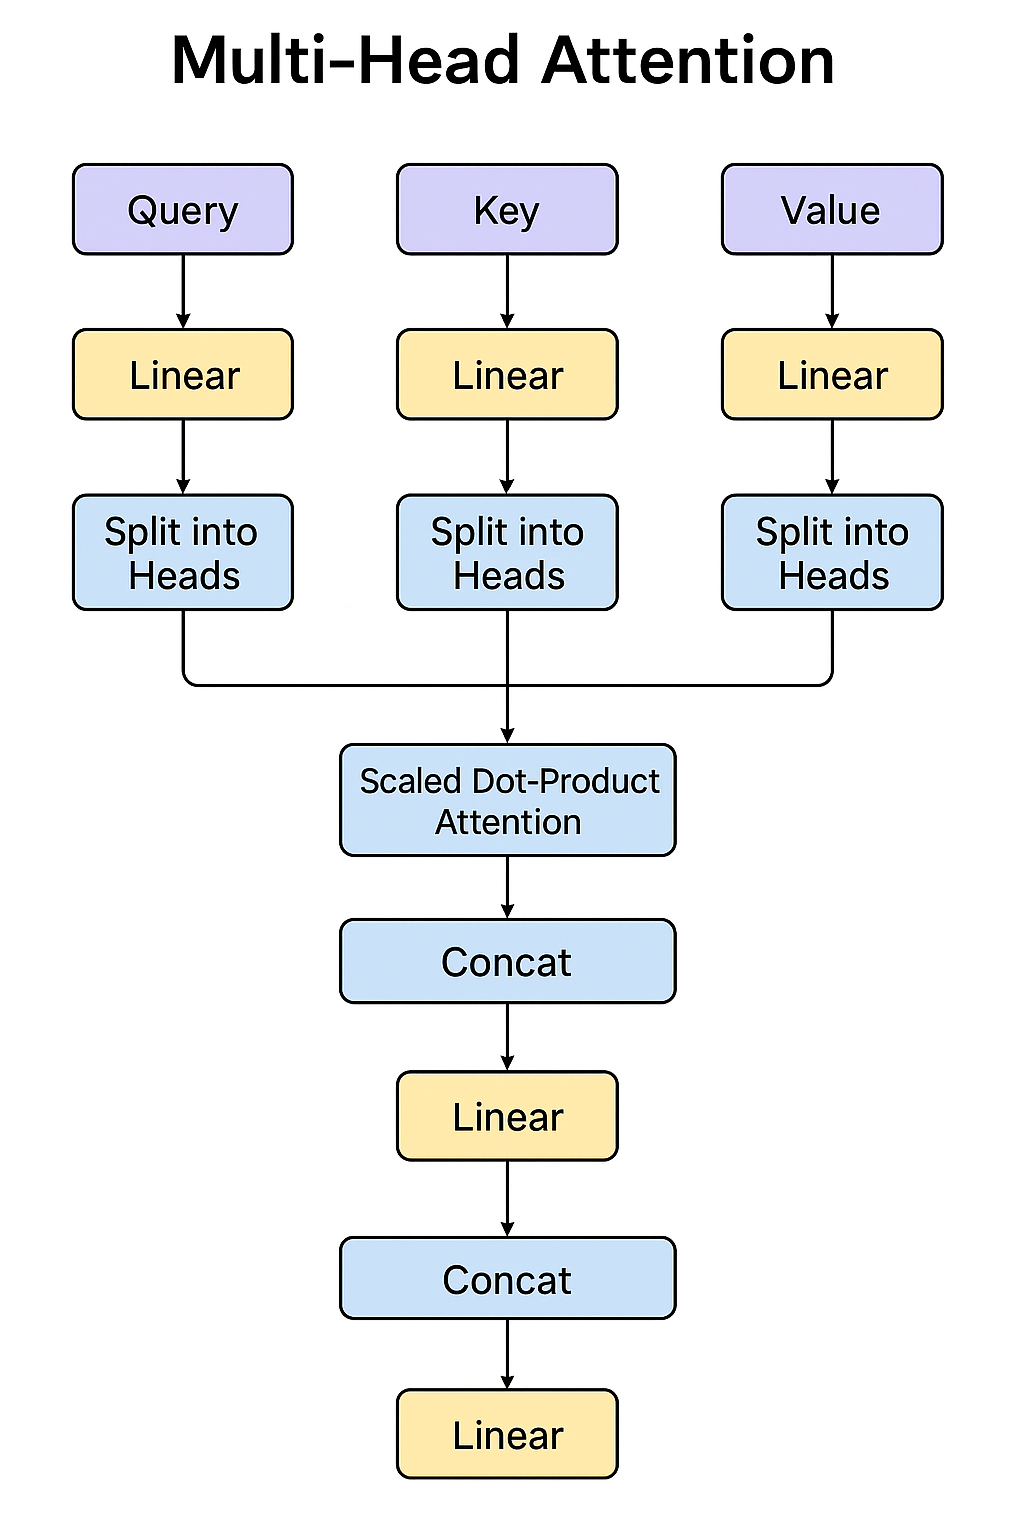

**图示说明：**
1. 输入（Input）：
-  通常是一个序列，例如句子的词向量，形状为 (batch_size, seq_len, embed_dim)。
2. 线性投影（Linear Projection）：
- 输入分别通过三个线性层投影为 Query (Q), Key (K), Value (V)。
- 每个投影的输出形状为 (batch_size, seq_len, embed_dim)。
3. 拆分多个头（Split Heads）：
- 将 Q, K, V 拆分为多个 head，每个 head 的维度为 head_dim = embed_dim / num_heads。
- 形状变为 (batch_size, num_heads, seq_len, head_dim)。
4. 注意力计算（Scaled Dot-Product Attention）：
- 对每个 head 执行：Attention(Q, K, V) = softmax(Q @ K.T / sqrt(head_dim)) @ V
- 这就是你之前提到的 a @ a.transpose(2, 3) 的操作。
5. 合并头（Concat Heads）：
- 将所有 head 的输出拼接回一个张量，形状为 (batch_size, seq_len, embed_dim)。
6. 输出线性层（Final Linear Layer）：
- 最终通过一个线性层，得到 Multihead Attention 的输出。


# 总结与收获

- 请参阅 [./multihead-attention.ipynb](./multihead-attention.ipynb) 代码笔记本，它是数据加载器（第2章）的简洁版本，加上我们在本章实现的多头注意力类，后续章节中训练GPT模型时将需要使用。
- 你可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到习题解答。

- `tril` keeps the lower triangle and zeros out the upper triangle.
- `triu` keeps the upper triangle and zeros out the lower triangle.

In [46]:
import torch

# Create a sample matrix
matrix = torch.arange(1, 17).reshape(4, 4)
print("Original matrix:")
print(matrix)

# Use tril to get the lower triangular part
lower_triangular = torch.tril(matrix)
print("\nLower triangular matrix (diagonal=0):")
print(lower_triangular)

# Use triu to get the upper triangular part
upper_triangular = torch.triu(matrix)
print("\nUpper triangular matrix (diagonal=0):")
print(upper_triangular)

# Example with a different diagonal
lower_triangular_diag1 = torch.tril(matrix, diagonal=1)
print("\nLower triangular matrix (diagonal=1):")
print(lower_triangular_diag1)

upper_triangular_diag_1 = torch.triu(matrix, diagonal=-1)
print("\nUpper triangular matrix (diagonal=-1):")
print(upper_triangular_diag_1)

Original matrix:
tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]])

Lower triangular matrix (diagonal=0):
tensor([[ 1,  0,  0,  0],
        [ 5,  6,  0,  0],
        [ 9, 10, 11,  0],
        [13, 14, 15, 16]])

Upper triangular matrix (diagonal=0):
tensor([[ 1,  2,  3,  4],
        [ 0,  6,  7,  8],
        [ 0,  0, 11, 12],
        [ 0,  0,  0, 16]])

Lower triangular matrix (diagonal=1):
tensor([[ 1,  2,  0,  0],
        [ 5,  6,  7,  0],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]])

Upper triangular matrix (diagonal=-1):
tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 0, 10, 11, 12],
        [ 0,  0, 15, 16]])
